# PROBLEM SET 2 - GROUP: REvolution

In [1]:
# Housekeeping (clear the workspace)
rm(list = ls())
# set the seed to reproduce the results
set.seed(100)
# call the file with functions
source("functions.R")

# Given Information

$y = X \beta + \epsilon $

$X_1$ is a constant

$X_2$ ~ $N(\mu_{X_2} = 0, \sigma_{X_2} =  \sqrt{1.5})$ 

$\beta = (5, -0.5)$

$N = 1000$

# Parameters

The following are the parameters used to draw our samples.

In [3]:
beta <- c(5, -0.5) # True population parameter
P <- length(beta)-1 # Number of rapameters excluding the intercept/ constant
constant <- 1 # The first variable, X1, is a constant
X_mu <- c(0) # Mean of the independent variable X2
X_sigma <- c(sqrt(1.5)) # Variance of the independent variable X2
eps_mu <- 0 # Mean of the error term
eps_sigma <- sqrt(10) # Variance the error term
N <- 500 # Number of sample observations/ draws

# Exercise 1.a

Since we use various samples throughout the problem set, we have created __generate_sample__, a function that draws sample data.

The inputs are:
1. "constant": the constant that will be used in the first column of the X matrix;
2. "beta": the vector $\beta$ containing the true population parameters (intercept included);
3. "P": the number of regressors (constant excluded). In this probem set $P=1$, just $X_2$;
4. "X_mu": the vector of regressor means (constant excluded);
5. "X_sigma": the vector of regressor standard deviations (constant excluded, of course);
6. "eps_mu": the mean of the error term $\epsilon$;
7. "eps_sigma": the standard deviation of the error term $\epsilon$;
8. "N": the number of observations, i.e. the number of rows of the $X$ matrix.

The function returns a list containing:
1. the $X$ matrix;
2. the $y$ vector;
3. the $\epsilon$ vector.

In [4]:
# Function drawing sample data
generate_sample <- function(constant, beta, P, X_mu, X_sigma, eps_mu, eps_sigma, N) {
    
  # Construct an empty matrix for X.
  X <- cbind(rep(constant, N), matrix(NA, N, P))

  for(p in 1:P) {
    # Draw observations from the true DGP for each X individually. 
    X[, p+1] <- c(rnorm(N, mean=X_mu[p], sd=X_sigma[p]))
    
  }
  
  # Draw random values for the error term.
  eps <- rnorm(N, eps_mu, eps_sigma) # Create hetero X[,2]^2* by changing the variance for each obs.
  
  # Calculate the response of the underlying DGP. 
  y <- X%*%beta+eps
  
  return(list(X=X, y=y, eps=eps))
}

Now we draw our first sample, i.e. the training sample.

In [5]:
sample_train <- generate_sample(constant, beta, P, X_mu, X_sigma, eps_mu, eps_sigma, N)

We access and store the $X$ matrix and the $y$ vector.

In [ ]:
X_train <- sample_train$X 
y_train <- sample_train$y

# Exercise 1.b

Now we do the same for the test sample.

In [6]:
sample_test <- generate_sample(constant, beta, P, X_mu, X_sigma, eps_mu, eps_sigma, N)

In [ ]:
X_test <- sample_test$X 
y_test <- sample_test$y

# Exercise 1.c

We create the function __betahat_calc__ that computes OLS estimates for $\beta$.

The inputs are:
1. the $X$ matrix;
2. the $y$ vector;
3. the number of regressors, constant excluded, $P$.

The function returns the vector of OLS estimates $\hat{ \beta }$.

In [7]:
# Function that computes OLS estimates
betahat_calc <- function(X, y, P) {

  # Check for collinearity 
  M <- t(X)%*%X
  if(det(M)!=0) {
    # If determinant is non-zero, calculate th estimator for beta. 
    beta.hat <- solve(t(X)%*%X, tol = 1e-17)%*%t(X)%*%y  
  } else {
      # Otherwise return NAs. 
      print("Matrix X'X is singular, OLS estimator cannot be derived.")
      beta.hat <- rep(NA, P+1)
  }
  
  return(beta.hat)
}

Now we call the function to compute the OLS estimates for the training sample data as per the exercise.

In [ ]:
beta.hat <- betahat_calc(X_train, y_train, P)

In [8]:
# Function that calculates the respective variance of the beta estimator(s)
betahat_covar_calc <- function(X, y, beta.hat) {
  # This function calculates the variance of the OLS estimator
  # INPUT:
  # X - vector or matrix, random draws for X incl. constant
  # y - vector, random draws for the response, y, length N
  # beta.hat - vector, containing OLS estimators, length P+1
  # OUTPUT:
  # covar - matrix/ scalar, variance of estimated OLS beta parameters
  if(length(beta.hat) == 1) {
    # calculate the residuals
    eps.hat <- y-X*beta.hat 
    k <- 1 
    n <- length(y) # Number of obs.
    se <- (eps.hat*eps.hat)/(n-k) # Calculate the standard error of residuals
    covar <- se[1]*solve(t(X)%*%X) # Calculate the Covariance matrix of estimated betas
    
  } else {
    # If there is more than one beta parameter, continue here...
    eps.hat <- y-X%*%beta.hat  #
    k <- dim(X)[2] # Number of paramters 
    n <- length(y)
    se <- (t(eps.hat)%*%(eps.hat))/(n-k) # Calculate the standard error of residuals
    covar <- se[1]*solve(t(X)%*%X) # Calculate the Covariance matrix of estimated betas
  }
  
  return(covar)
}

In [9]:
# Calculate the respective variance of the beta estimator(s)
beta.hat.covar <- betahat_covar_calc(X_train, y_train, beta.hat)

# Combine the estimator and its variance in a table
(betahat_table <- cbind(beta.hat, diag(beta.hat.covar)))

5.223933,0.02228451
-0.527710,0.01472000


# Exercise 1.d

The following __error_calc__ function computes mean squared errors (MSE) and average prediction errors (APE).

The inputs are:
1. the $X$ matrix;
2. the $y$ vector;
3. the $\hat{\beta}$ vector. When computing the APE for the test sample, $\hat{\beta}$ is the vector of parameter estimates computed for the training sample.

The function returns the scalar __error__, the MSE (or APE).

In [10]:
# Function that calculates MSE and APE
error_calc <- function(X, y, beta.hat) {
  
  if(length(beta.hat) == 1) {
    # Calculate the fitted values 
    y.hat <- X*beta.hat
  
  } else {
    # If there is more than one parameter, calculate the fitted values as follows
      y.hat <- X%*%beta.hat
      
  }
  
  # Calculate the error: MSE/ APE
  error = (1/length(y.hat))*sum((y-y.hat)^2)
  
  return(error)
}

We compute the MSE and APE for our two samples.

In [11]:
(mse <- error_calc(X_train, y_train, beta.hat))
(ape <- error_calc(X_test, y_test, beta.hat))

[1] 11.08214

[1] 9.394584

# Exercise 1.e

Now we create the __add_polynom__ function to change the degree of the polynomial for the variables in the $X$ matrix.

The input arguments are:
1. the $X$ matrix, where the first column is always supposed to contain the constant (1);
2. "polymax" is the maximum degree of the polynomial;
3. the number of variables (regressors excluding the constant) $P$;
4. the number of observations $N$.

The function returns __X.polynom__ which is a new matrix with the desired complete polynomial of the $X$ matrix variables.

In [12]:
# Function to add polynomials
add_polynom <- function(X, polymax, P, N) {

  if(polymax == 0) {
    # If polynomial is set to 0, then a constant remains only.
    X.polynom <- rep(1, N)
    return(X.polynom)
  }
  
  else(polymax > 0)
  # Otherwise, add the respective polynomials of each variable, respectively,
  # expanding X.
    X.polynom <- cbind(rep(1, N), matrix(NA, N, P*polymax))
    col <- 2
    for(p in 1:P) {
    # Loop over the number of parameters.
      for(i in 1:polymax) {
        # Loop over the polynomial degrees. 
        X.polynom[,col] <- X[,p+1]^i
        col <- col+1
      }
    }
  
    return(X.polynom)  
}

We use the function to create the required 4-th degree polynomial.

In [13]:
# Set the max. polynimial degree.
polymax <- 4
# Extend the X matrix by the polynomials of each variable, respectively.
X.polynom_train <- add_polynom(X_train, polymax, P, N)
head(X.polynom_train)

1,-0.6150575,0.378295735,-0.2326736315,1.431077e-01
1,0.1610921,0.025950671,0.0041804486,6.734373e-04
1,-0.0966533,0.009341861,-0.0009029217,8.727036e-05
1,1.0860851,1.179580947,1.2811253470,1.391411e+00
1,0.1432600,0.020523417,0.0029401840,4.212107e-04
1,0.3902406,0.152287699,0.0594288378,2.319154e-02


In [14]:
X.polynom_test <- add_polynom(X_test, polymax, P, N)
head(X.polynom_test)

1,1.3443414,1.8072538,2.4295660,3.2661661
1,1.4464684,2.0922708,3.0264036,4.3775972
1,0.7195507,0.5177532,0.3725497,0.2680684
1,1.3180368,1.7372211,2.2897215,3.0179372
1,1.3921098,1.9379697,2.6978667,3.7557267
1,0.9311645,0.8670674,0.8073824,0.7518059


In [15]:
# # Use the 'picker' function to select the right columns of interest
pick_col_for_poly <- function(polynom, polymax, P) {
  # Pick specific column from the X matrix for estimating the OLS beta
  # INPUT:
  # polynom - scalar, polynomial degree that you are interested in only, e.g. for OLS
  # polymax - scalar, max. nr of polynomials to consider
  # P - scalar, number of parameters, excl. the constant
  # OUTPUT: 
  # picker - vector, columns of interest  
  # Initialize the indice and vectors to store specific colums
  poly <- 0
  pvec <- c()
  picker <- c()
  
  if(polynom==0) {
    picker <- 1
  } else {
    for(par in 1:P) {
      # Pick the first column of each variable by looping
      # over the nr. of parameters, excl. the constant.
      pvec <- c(pvec, 2+poly)
      poly <- poly + polymax
    }
    
    for(pol in 1:polynom) {
      # Now include all the respective polynomials of each
      # parameter, respectively.
      picker <- c(picker, pvec+(pol-1))
    }
    picker <- c(1, picker)
  }

  return(picker)
}

In [16]:
# Decice which degree of polynomial you want to look at, choose polynom (which does not have to be equal to polymax).
# Use polymax for polynom if you want to look at all polynomial degrees. 
polynom <- 4
(col_picker <- pick_col_for_poly(polynom, polymax, P))

[1] 1 2 3 4 5

In [17]:
# Estimate the betas for the polynomial degrees chosen

# Initialize matrices to store the results
beta.hat.polynom <- matrix(NA, polymax+1, (P*polynom)+1) # For the beta estomators
beta.hat.polynom_var <- matrix(NA, polymax+1, (P*polynom)+1) # For the variance of the estimators
error.polynom <- matrix(NA, polymax+1, 2) # For the respective errors, MSE/ APE

polynom_func <- function(polymax, pol, P, X.polynom_train, X.polynom_test, y_train, y_test) {
  # This function does everything stated above. It uses the X matrix with the polynomial degrees of the variables from X and 
  # calculates the OLS estimator,  its variance and errors, MSE/ APE.
  #
  # INPUT:
  # polymax - scalar, max nr. of polynomial degree
  # pol - scalar, polynom of interest
  # P - scalar, numebr of paramteres excl. intercept
  # X.polynom_train - matrix, including the constant and the respective polynomials of the variables
  # y_train - vector, length N, repsonse of the training sample
  # y_test - vector, length N, repsonse of the test sample
  # OUTPUT:
  # list - the list includes:
  # beta - estimates for beta, beta_var - its variance, error - and the MSE/ APE, repsectively
  for(pol in 0:polymax) {
    col_picker <- pick_col_for_poly(pol, polymax, P) # Pick columsn of interest
    X_train_select <- X.polynom_train[, col_picker] # Select only these columns
    X_test_select <- X.polynom_test[, col_picker]
    # Estimate the beta parameters and store the result
    beta.hat.polynom[pol+1, 1:(pol+1)] <- betahat_calc(X_train_select, y_train, P) 
    
    # Estimate the corresponsing variance and storethe result
    covar <- betahat_covar_calc(X_train_select, y_train, beta.hat.polynom[pol+1, 1:(pol+1)])
    beta.hat.polynom_var[pol+1, 1:(pol+1)] <- diag(covar) # Diagonal/ variance elements for each parameter.
    
    # Estimate the errors: MSE/ APE
    error.polynom[pol+1, 1] <- error_calc(X_train_select, y_train, beta.hat.polynom[pol+1, 1:(pol+1)])
    error.polynom[pol+1, 2]  <- error_calc(X_test_select, y_test, beta.hat.polynom[pol+1, 1:(pol+1)])
  }
  return(list(beta = beta.hat.polynom, beta_var = beta.hat.polynom_var, error = error.polynom))
}

In [18]:
# Calculate the OLS estimators, its variance and the respective errors: MSE/APE  for the polynomials, respectively.
# List with: beta - estimates for beta, beta_var - its variance, error - and the MSE/ APE, respectively
list_polynom <- polynom_func(polymax, pol, P, X.polynom_train, X.polynom_test, y_train, y_test)
(beta.hat.polynom <- list_polynom$beta)
beta.hat.polynom_var <- list_polynom$beta_var
(error.polynom <- list_polynom$error)

5.248240,NA,NA,NA,NA
5.223933,-0.5277100,NA,NA,NA
5.089958,-0.5081959,0.08909079,NA,NA
5.079313,-0.8155092,0.10285954,0.06075208,NA
5.068586,-0.8145316,0.11772607,0.06057398,-0.001525259


11.50313,9.787329
11.08214,9.394584
11.03946,9.442580
10.94692,9.563445
10.94664,9.569466


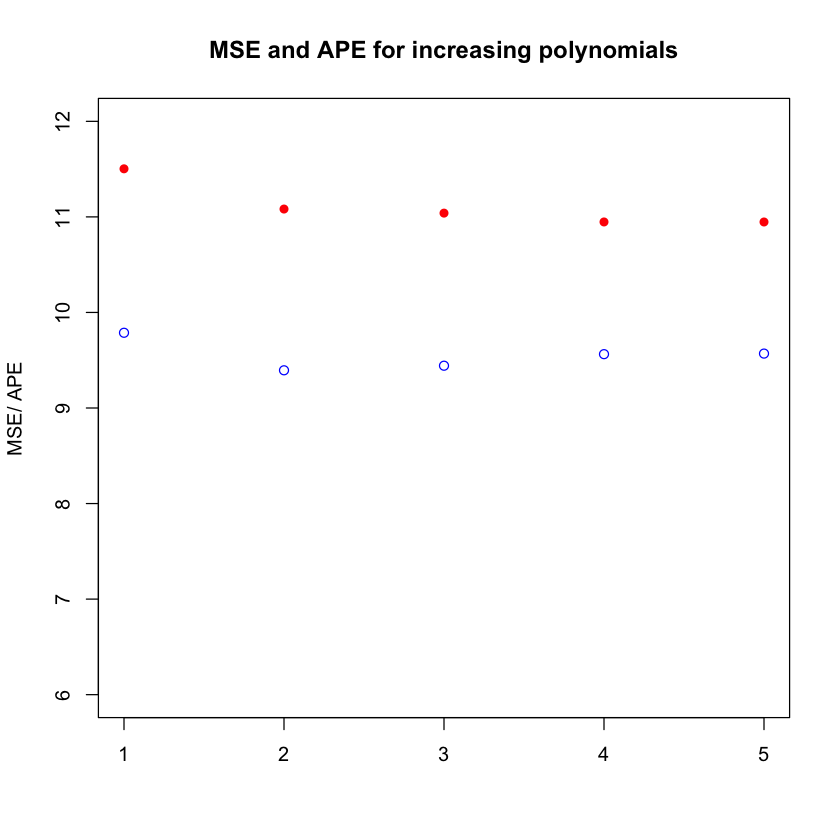

In [19]:
# Plot the MSE/ APE for the polynomial degrees
plot(error.polynom[,1], type="p", col="red", 
     main="MSE and APE for increasing polynomials",
     xlab="", ylab="MSE/ APE", pch=16,
     ylim = c(6,12), xlim = c(1, 5))
lines(error.polynom[, 2], type="p", col="blue")

# Exercise 2.a

In [20]:
sim <- 1000 # Nr. of simulatons
polymax <- 4 # Max. degree of polynomial
polynom <- 4 # Polynomial degree of interest

# Initialize the matrices to store results of beta estimators and its variances, the MSE and the APE for all polynomial
# degrees, respectively. 
BETAHAT <- matrix(NA, polynom+1, polynom+1)
BETAHAT_VAR <- matrix(NA, polynom+1, polynom+1)
MSE <- matrix(NA, polynom+1, sim)
APE <- matrix(NA, polynom+1, sim)

for(si in 1:sim) {
  # Run the simulation sim times. 
  
  # Draw training and test samples.
  sample_train <- generate_sample(constant, beta, P, X_mu, X_sigma, eps_mu, eps_sigma, N)
  sample_test <- generate_sample(constant, beta, P, X_mu, X_sigma, eps_mu, eps_sigma, N)
  
  # Save the X and y from the training sample.
  X_train <- sample_train$X 
  y_train <- sample_train$y
  X_test <- sample_test$X
  y_test <- sample_test$y

  # Extend the X matrix by the polynomials of each variable, respectively.
  X.polynom_train <- add_polynom(X_train, polymax, P, N) 
  X.polynom_test <- add_polynom(X_test, polymax, P, N) 
    
  # Pick the columsn acording to the polynomial degree of choice, polynomial (not polymax!).
  col_picker <- pick_col_for_poly(polynom, polymax, P)
  
  # Initialize matrices to store results
  beta.hat.polynom <- matrix(NA, polymax+1, (P*polynom)+1) # For the OLS estimators
  beta.hat.polynom_var <- matrix(NA, polymax+1, (P*polynom)+1) # For the variance of estimators
  error.polynom <- matrix(NA, polymax+1, 2) # For the errors, MSE/ APE
  
  # Apply the polynomial function as decribed above, to get the results for the
  # polynomial degrees, respectively: 
  list_polynom <- polynom_func(polymax, polynom, P, X.polynom_train, X.polynom_test, y_train, y_test)
  beta.hat.polynom <- list_polynom$beta
  beta.hat.polynom_var <- list_polynom$beta_var
  error.polynom <- list_polynom$error
  
  if(si == 1) {
    # For the first time, we have to save the results here
    BETAHAT <- beta.hat.polynom # Store the OLS estimator
    BETAHAT_VAR <- beta.hat.polynom_var # Store the variance
    MSE[, si] <- error.polynom[, 1] # Store the MSE
    APE[, si] <- error.polynom[, 2] # Store the MSE
    
  } else
    # For other simulation runs, we add the results and take the average
    BETAHAT <- (BETAHAT + beta.hat.polynom) / 2
    BETAHAT_VAR <- (BETAHAT_VAR + beta.hat.polynom_var)/ 2
    # For the erros, we dont take the average and do it in a later step.
    # We just store it in a matrix
    MSE[, si] <- error.polynom[, 1] # Store the MSE
    APE[, si] <- error.polynom[, 2] # Store the MSE
}

In [22]:
# Create a joint matrix as a table of the estimators and
# the respective variances.
BETAHAT
BETAHAT_VAR
BETAHAT_TABLE <- cbind(BETAHAT, BETAHAT_VAR)
BETAHAT_TABLE

4.824413,NA,NA,NA,NA
4.823626,-0.4759436,NA,NA,NA
4.767178,-0.4806786,0.03898535,NA,NA
4.767848,-0.5135682,0.03845391,0.009202713,NA
4.715483,-0.5110251,0.11663150,0.008479893,-0.009755343


0.0000135685,NA,NA,NA,NA
0.0202371792,0.01410729,NA,NA,NA
0.0299701259,0.01417155,0.004772823,NA,NA
0.0300241730,0.03679125,0.004831705,0.001229359,NA
0.0403734080,0.03711225,0.026767530,0.001258902,0.0003364055


4.824413,NA,NA,NA,NA,0.0000135685,NA,NA,NA,NA
4.823626,-0.4759436,NA,NA,NA,0.0202371792,0.01410729,NA,NA,NA
4.767178,-0.4806786,0.03898535,NA,NA,0.0299701259,0.01417155,0.004772823,NA,NA
4.767848,-0.5135682,0.03845391,0.009202713,NA,0.0300241730,0.03679125,0.004831705,0.001229359,NA
4.715483,-0.5110251,0.11663150,0.008479893,-0.009755343,0.0403734080,0.03711225,0.026767530,0.001258902,0.0003364055


# Exercise 2.b

In [23]:
# Calculate the average training MSE and the average  prediction error using the expressions given below and
# store the results in a vector.
(aMSE <- rowMeans(MSE)) # Average MSE over sim simulations for all polynomial degrees
(aAPE <- rowMeans(APE)) # Average APE over sim simulations for all polynomial degrees

[1] 10.324451  9.930970  9.909543  9.890678  9.871187

[1] 10.38787 10.03502 10.05690 10.08316 10.12768

# Exercise 2.c

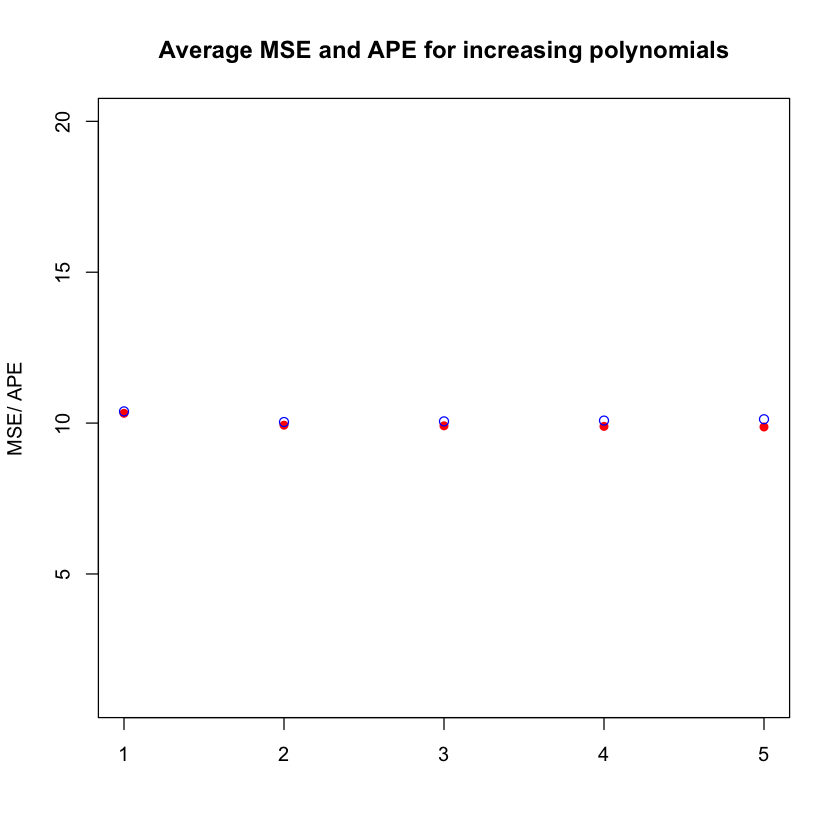

In [24]:
# Plotting of the errors
plot(aMSE, type="p", col="red", 
     main="Average MSE and APE for increasing polynomials",
     xlab="", ylab="MSE/ APE", pch=16,
     ylim = c(1,20), xlim = c(1, 5))
lines(aAPE, type="p", col="blue")

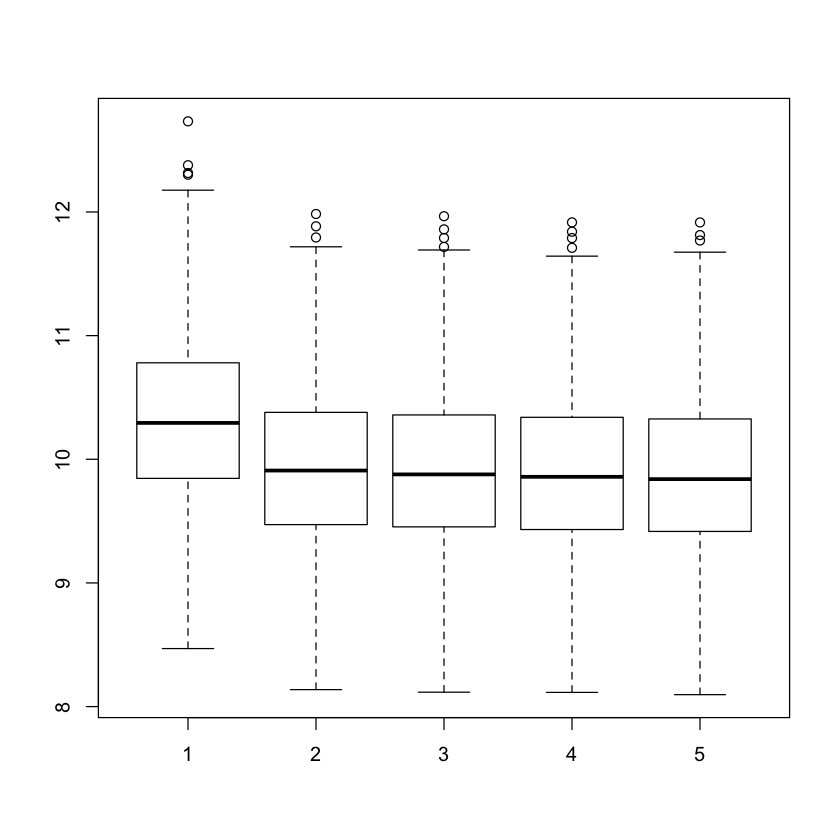

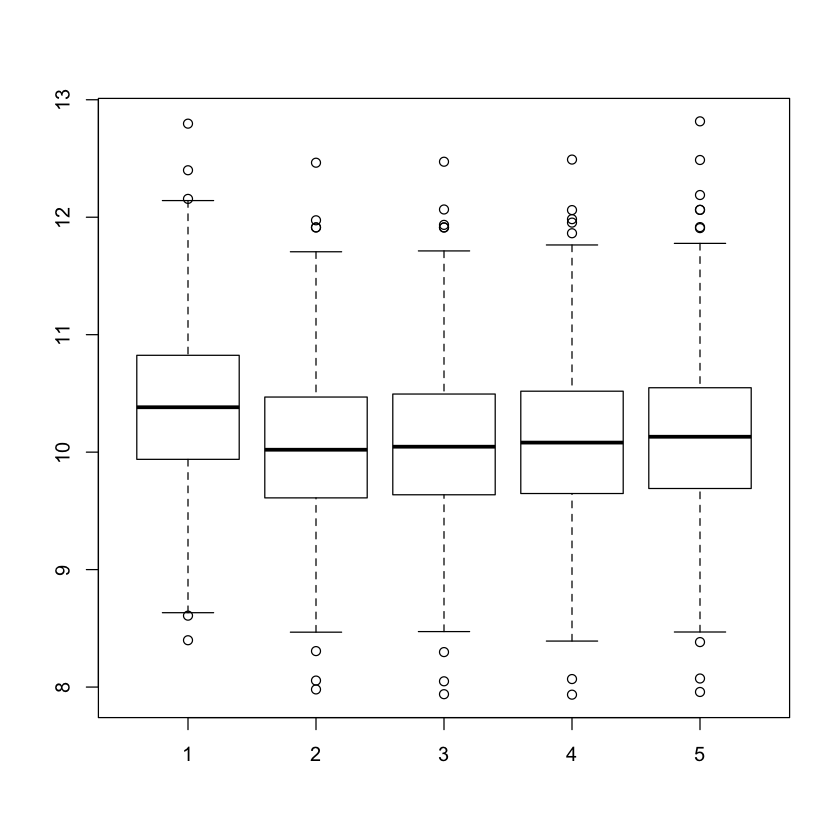

In [25]:
# Boxplot of all the sim errors: MSE/ APE
boxplot(MSE[1,], MSE[2,], MSE[3,], MSE[4,], MSE[5,])
boxplot(APE[1,], APE[2,], APE[3,], APE[4,], APE[5,])

# Exercise 2.d

In [45]:
demo_function <- function(draws, eps_sigma, X_sigma_seq, constant, beta, P, X_mu, eps_mu) {
  # This function is just created for demostratin purposes. 
  myseq <- c(10:draws)

  betahat_seq_list <- list()
  betahat_var_seq_list <- list()
  error_seq <- matrix(NA, 2, length(myseq))
  
  ci <- 1
  for(seqi in myseq) {
    sample_train_seq <- generate_sample(constant, beta, P, X_mu, X_sigma_seq, eps_mu, eps_sigma, seqi)
    sample_test_seq <- generate_sample(constant, beta, P, X_mu, X_sigma_seq, eps_mu, eps_sigma, seqi)
    X_train_seq <- sample_train_seq$X # Save the X and y from the training sample.
    y_train_seq <- sample_train_seq$y
    X_test_seq <- sample_test_seq$X
    y_test_seq <- sample_test_seq$y
    
    betahat_seq <- betahat_calc(X_train_seq, y_train_seq, P)
    betahat_var_seq <- betahat_covar_calc(X_train_seq, y_train_seq, betahat_seq)
    
    betahat_seq_list[[ci]] <- betahat_seq
    betahat_var_seq_list[[ci]] <- diag(betahat_var_seq)
    
    error_seq[1, ci] <- error_calc(X_train_seq, y_train_seq, betahat_seq) # MSE
    error_seq[2, ci] <- error_calc(X_train_seq, y_test_seq, betahat_seq) # APE
    
    ci <- ci + 1
  }

  betahat_seq_mat <- do.call(cbind, betahat_seq_list)
  betahat_var_seq_mat <- do.call(cbind, betahat_var_seq_list)

  return(list(beta = betahat_seq_mat, var = betahat_var_seq_mat, error =  error_seq))
}

In [46]:
# Some functions for plots
plot_beta_func <- function(betahat_demo, cylim, draws) {
  plot(betahat_demo[1,], type="p", col="red", main="OLS estimators for increasing N",
       xlab="observations", ylab="beta estimator", pch=16,
       ylim = cylim, xlim = c(1, draws))
  lines(betahat_demo[2, ], type="p", col="blue")
  
  abline(h = 5, col="red")
  abline(h = -0.5, col="blue")
}

plot_var_func <- function(betahat_var_demo, cylim, draws) {
  plot(betahat_var_demo[1, ], type="p", col="red",
       main="Variance of OLS estimators for increasing N",
       xlab="observations", ylab="Variance", pch=16,
       ylim = cylim, xlim = c(1, draws))
  lines(betahat_var_demo[2, ], type="p", col="blue")
  abline(h = -0.5, col="black")
} 

plot_error_func <- function(error_demo, cylim, draws) {
  plot(error_demo[1, ], type="p", col="red",
    main="MSE and APE",
    xlab="observations", ylab="MSE/ APE", pch=16,
    ylim = cylim, xlim = c(1, draws))
    lines(error_demo[2, ], type="p", col="blue")
}

In [47]:
# As we already know var_beta = eps2 * X'X
# 
# Parameters N, Variance of errors, Variance of independent variable(s), Number of sim affect 
# the preciseness of beta estimators, variance of beta estimators, t
# EXPECT:
# - beta is closer to the true value
# - variance of beta reduces
# - MSE and APE converge to the true value 

draws <- 1000 # Number of observations/ random draws for X and y
eps_sigma <- sqrt(10) # larger error variance: 10
X_sigma_seq <- c(sqrt(1.5)) # larger X variance: 2

In [48]:
# Produce the demostratin results here
demo_results <- demo_function(draws, eps_sigma, X_sigma_seq, constant, beta, P, X_mu, eps_mu)

# Store the results
betahat_demo <- demo_results$beta # Store the OLS estimators
betahat_var_demo <- demo_results$var # Store the estimators' variance
error_demo <- demo_results$error # Store the errors: MSE/ APE

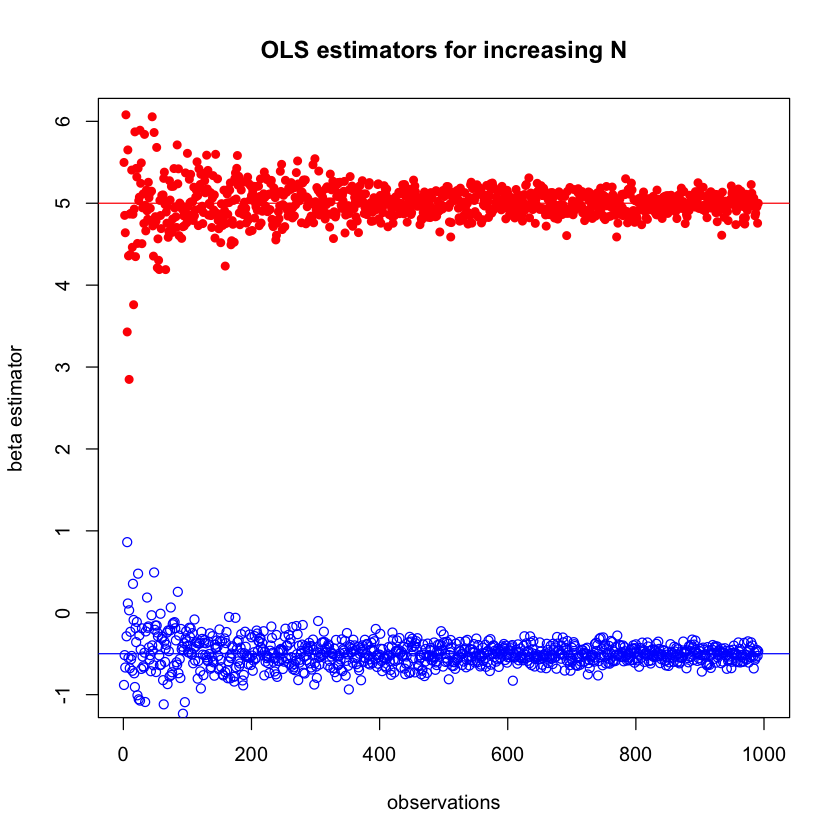

In [49]:
# Plot beta estimates from the demo
cylim <- c(-1, 6)
plot_beta_func(betahat_demo, cylim, draws)

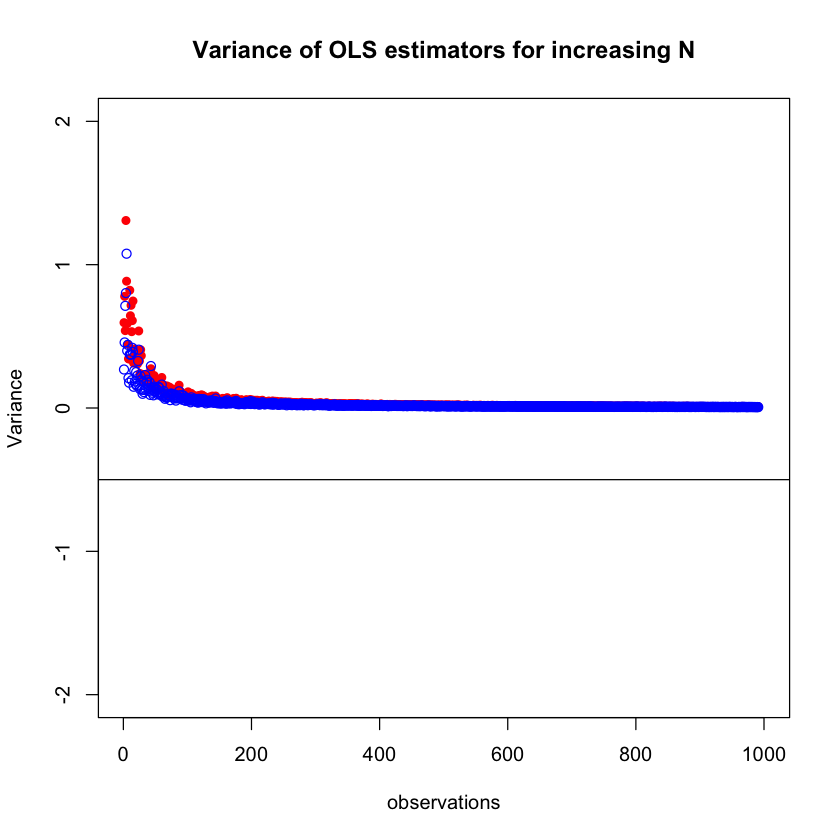

In [50]:
# Plot the variances from the demo
cylim <- c(-2, 2)
plot_var_func(betahat_var_demo, cylim, draws)

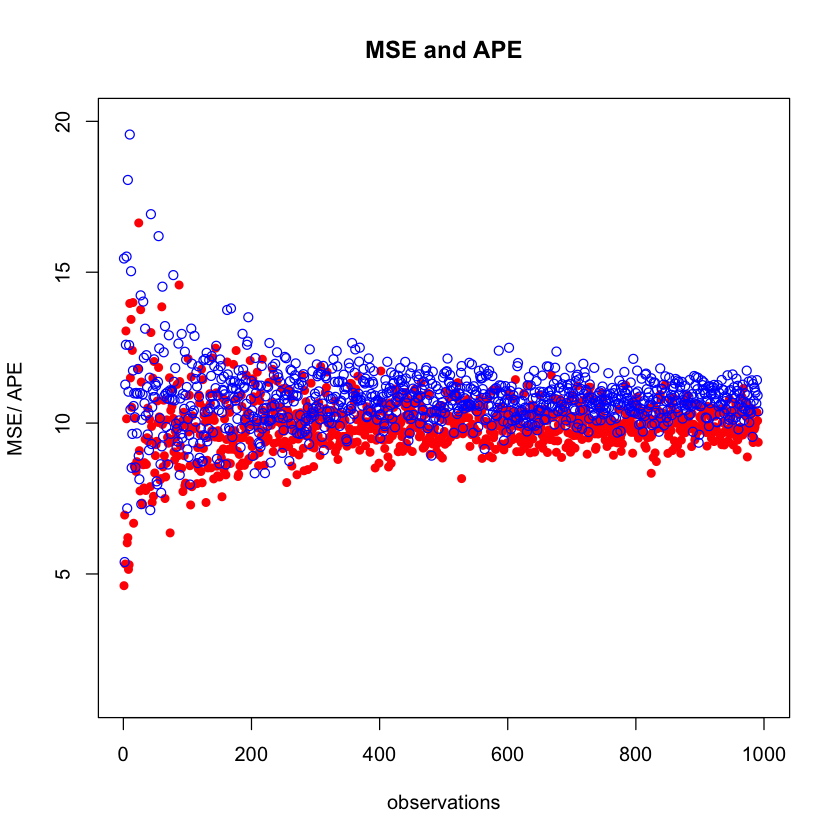

In [51]:
# Plot the MSE and APE from the demo
cylim <- c(1,20)
plot_error_func(error_demo, cylim, draws) 

### Now lets change N...

In [33]:
draws <- 50 # Number of observations/ random draws for X and y
eps_sigma <- sqrt(10) # larger error variance: 10
X_sigma_seq <- c(sqrt(1.5)) # larger X variance:2

demo_results <- demo_function(draws, eps_sigma, X_sigma_seq, constant, beta, P, X_mu, eps_mu)

# Store the results
betahat_demo <- demo_results$beta # Store the OLS estimators
betahat_var_demo <- demo_results$var # Store the estimators' variance
error_demo <- demo_results$error # Store the errors: MSE/ APE

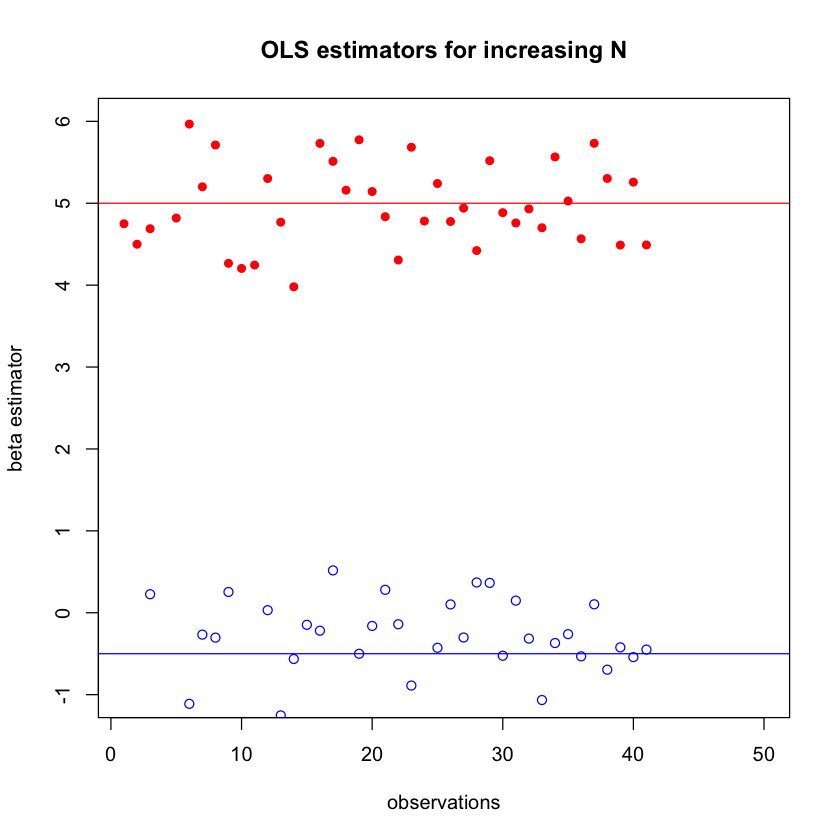

In [34]:
# Plot beta estimates from the demo
cylim <- c(-1, 6)
plot_beta_func(betahat_demo, cylim, draws)

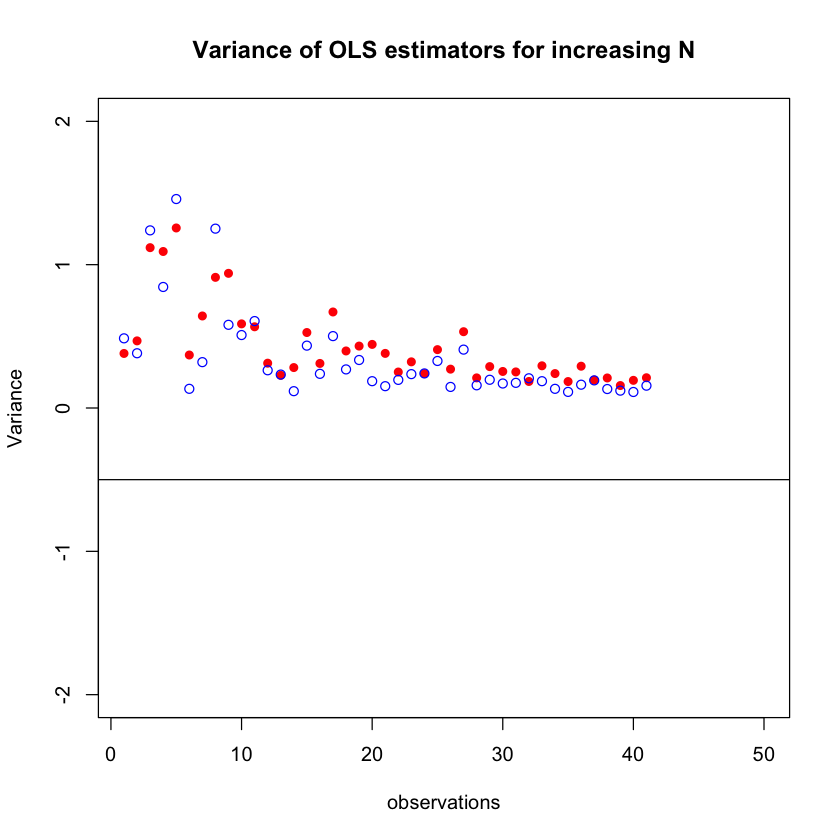

In [35]:
# Plot the variances from the demo
cylim <- c(-2, 2)
plot_var_func(betahat_var_demo, cylim, draws)

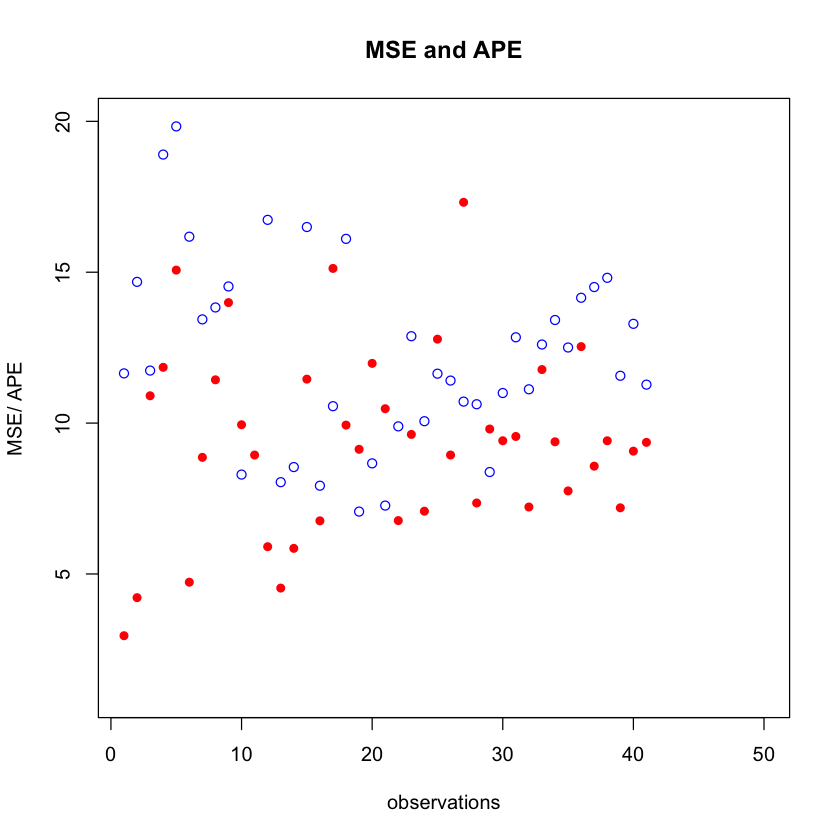

In [36]:
# Plot the MSE and APE from the demo
cylim <- c(1,20)
plot_error_func(error_demo, cylim, draws) 

### Now lets change eps_sigma ...

In [37]:
draws <- 1000 # Number of observations/ random draws for X and y
eps_sigma <- 10 # sqrt(10), larger error variance: 10
X_sigma_seq <- c(sqrt(1.5)) # larger X variance:2

demo_results <- demo_function(draws, eps_sigma, X_sigma_seq, constant, beta, P, X_mu, eps_mu)

# Store the results
betahat_demo <- demo_results$beta # Store the OLS estimators
betahat_var_demo <- demo_results$var # Store the estimators' variance
error_demo <- demo_results$error # Store the errors: MSE/ APE

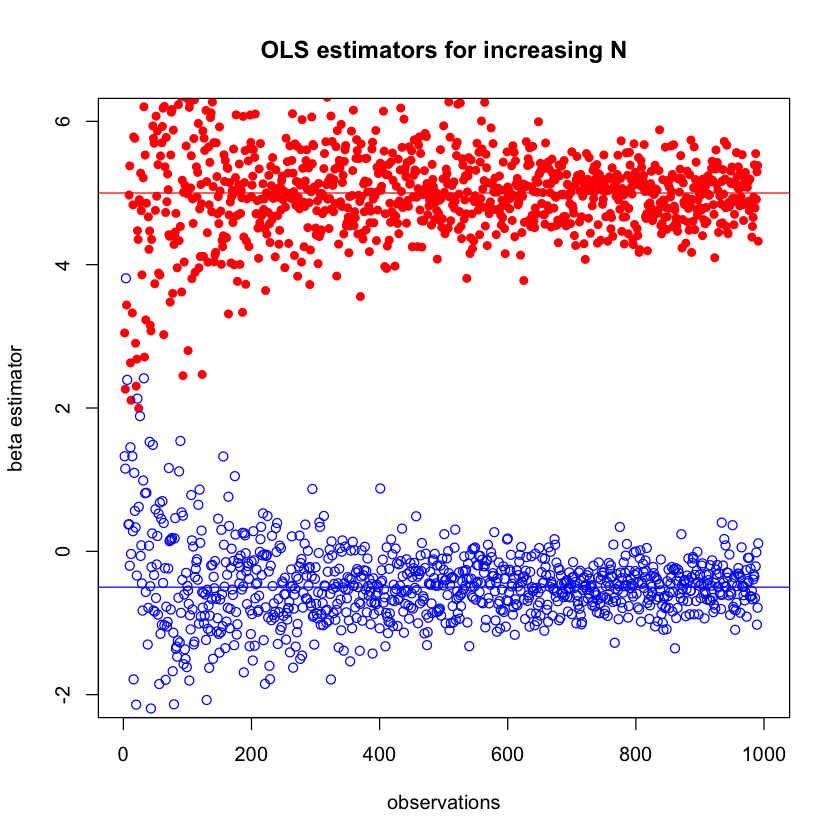

In [38]:
# Plot beta estimates from the demo
cylim <- c(-2, 6)
plot_beta_func(betahat_demo, cylim, draws)

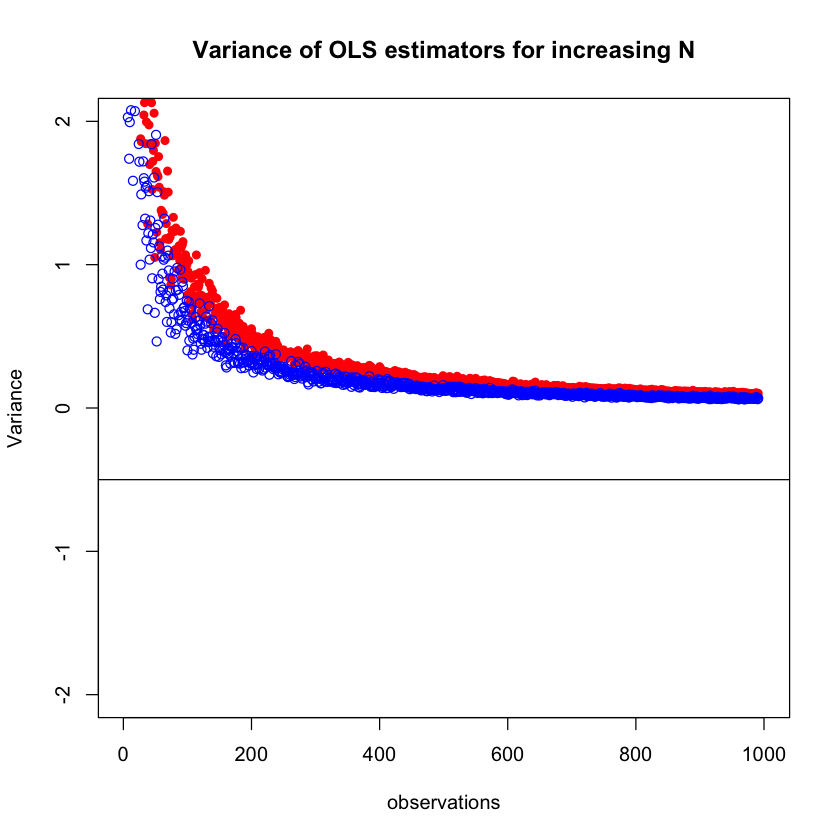

In [39]:
# Plot the variances from the demo
cylim <- c(-2, 2)
plot_var_func(betahat_var_demo, cylim, draws)

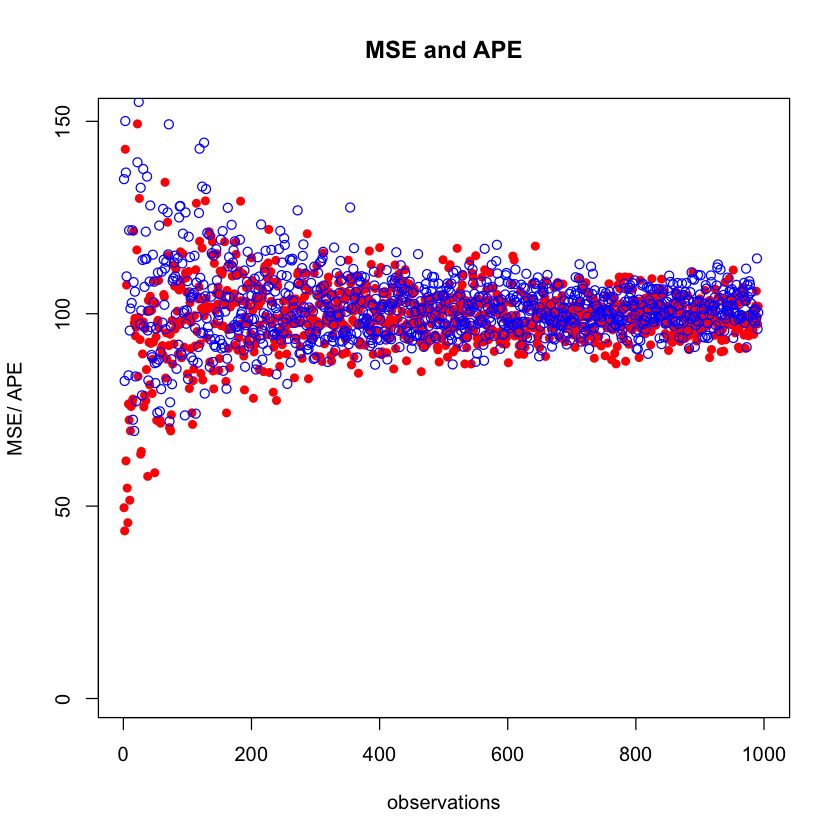

In [40]:
# Plot the MSE and APE from the demo
cylim <- c(1,150)
plot_error_func(error_demo, cylim, draws) 

### Now lets change X_sigma_seq ... 

In [41]:
draws <- 1000 # Number of observations/ random draws for X and y
eps_sigma <- sqrt(10) # larger error variance: 10
X_sigma_seq <- 2 # c(sqrt(1.5)),larger X variance:2

demo_results <- demo_function(draws, eps_sigma, X_sigma_seq, constant, beta, P, X_mu, eps_mu)

# Store the results
betahat_demo <- demo_results$beta # Store the OLS estimators
betahat_var_demo <- demo_results$var # Store the estimators' variance
error_demo <- demo_results$error # Store the errors: MSE/ APE

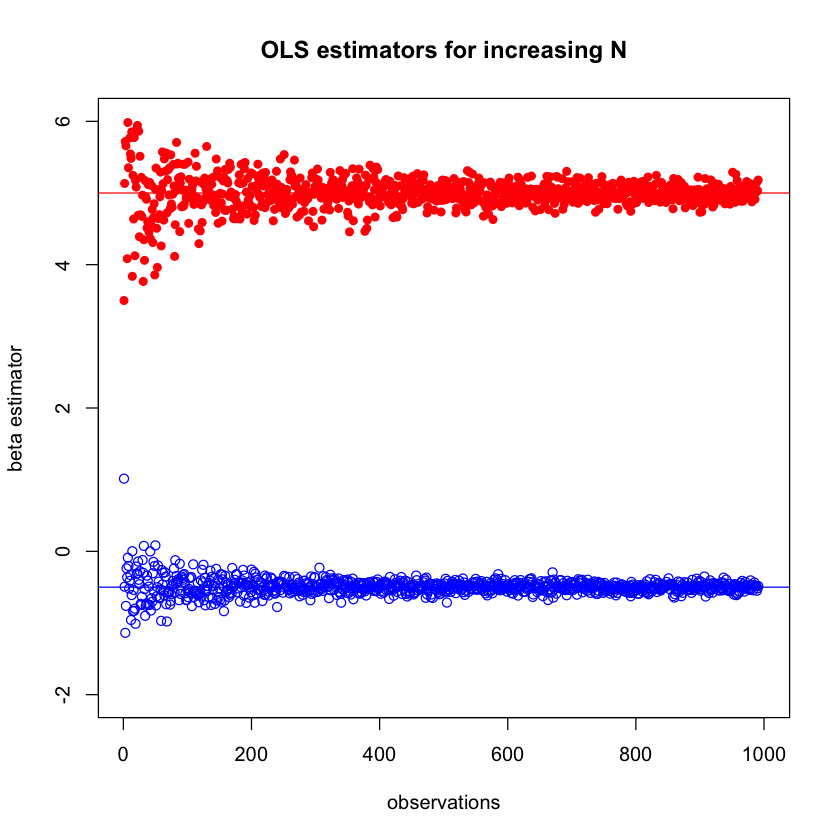

In [42]:
# Plot beta estimates from the demo
cylim <- c(-2, 6)
plot_beta_func(betahat_demo, cylim, draws)

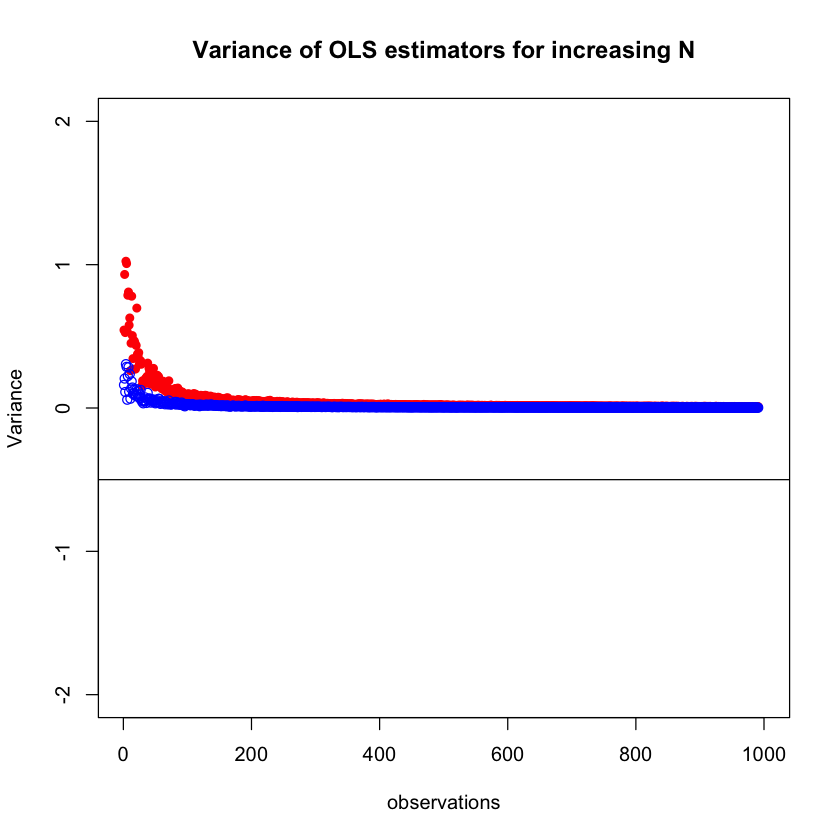

In [43]:
# Plot the variances from the demo
cylim <- c(-2, 2)
plot_var_func(betahat_var_demo, cylim, draws)

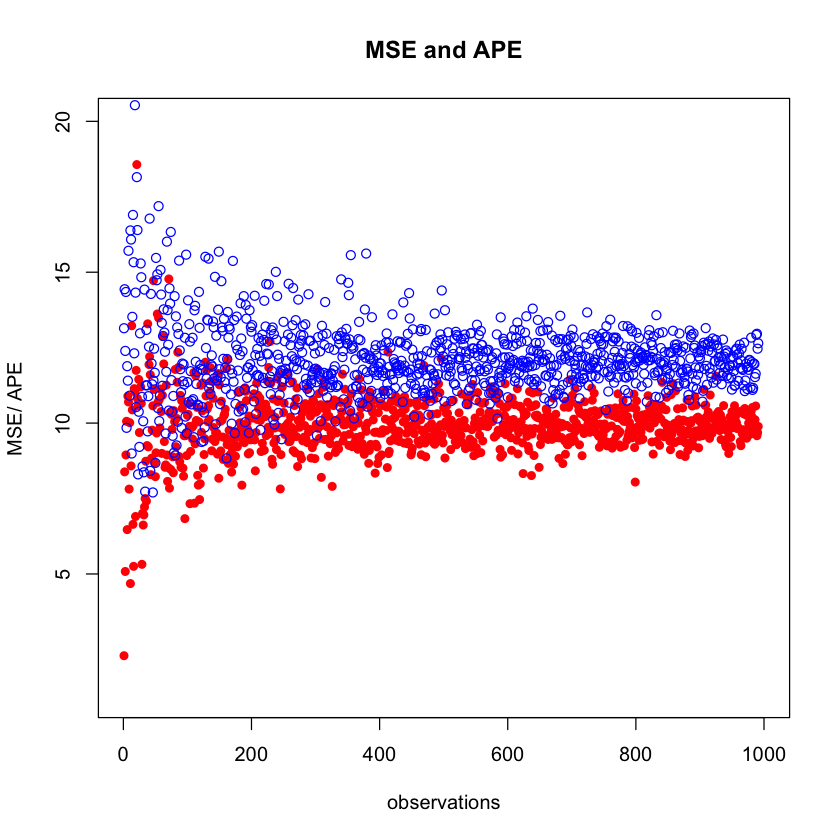

In [44]:
# Plot the MSE and APE from the demo
cylim <- c(1,20)
plot_error_func(error_demo, cylim, draws) 